In [109]:
import json

import shapely.geometry
import geopandas as gpd
import geopandas_osm.osm

meta_df = gpd.read_file('MUL-PanSharpen/vegas_image_summary.geojson')
poly = shapely.geometry.box(*meta_df.unary_union.bounds)

osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='building')
building_columns = osm_df.columns

#buildings = osm_df[~osm_df.building.isnull()][['building', 'name', 'geometry']]
#building_centroids = buildings.set_geometry(buildings.centroid, inplace=False)
#building_centroids.to_file('vectors/building_centers.geojson', 'GeoJSON')

In [110]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio

%matplotlib inline


def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image to uint8 values.  This helps to deal with 11-bit imagery.
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
    return img_scaled

## Merge solar panel footprint from QGIS with image

In [119]:
filename1 = '/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/Panel_Masks/MUL-PanSharpen_AOI_2_Vegas_img3888_panels.geojson'

filename2 = 'MUL-PanSharpen/MUL-PanSharpen_AOI_2_Vegas_img3888.tif'

filename3 = 'geojson/buildings/buildings_AOI_2_Vegas_img3888.geojson'

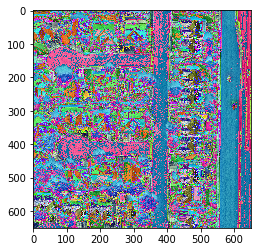

In [120]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

src = rasterio.open(filename2)

# Load the RGB bands and transpose the image shape
img = src.read([5,3,2]).transpose([1,2,0])

# Plot it
plt.imshow(img)

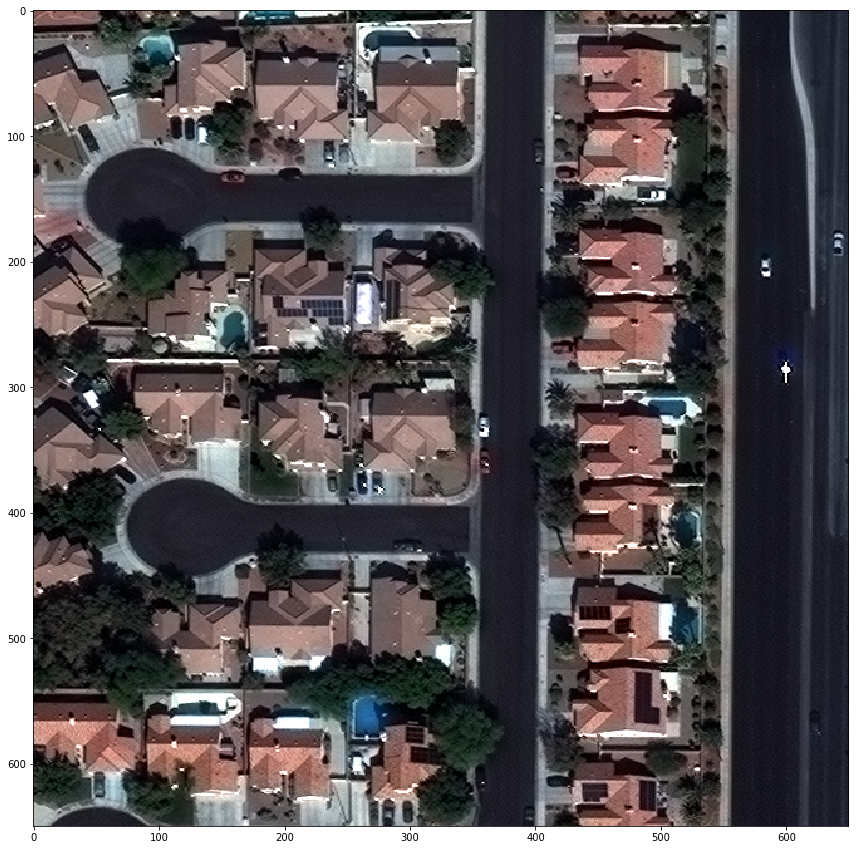

In [121]:
def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image for display
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    
    for i in range(img.shape[2]):
        
        band = img[:, :, i]
        
        # Pick out the lower and upper percentiles
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        
        # Normalize the band
        band = (band - lower) / (upper - lower) * 255
        
        # Clip the high and low values, and cast to uint8
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
        
    return img_scaled


# Plot the rescaled image
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(scale_bands(img))

In [122]:
pwd

u'/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train'

In [123]:
import pandas as pd
meta_df = gpd.read_file(filename1)
#poly = shapely.geometry.box(*meta_df.unary_union.bounds)
#meta_df = pd.read_json('geojson/buildings/buildings_AOI_2_Vegas_img1214.geojson')



In [124]:
meta_df.head()

geometry  id
0  POLYGON ((-115.2085707468973 36.2452054513361,...   1
1  POLYGON ((-115.2084514715113 36.24522295964965...   2
2  POLYGON ((-115.2084788282512 36.24529955852138...   3
3  POLYGON ((-115.2084372460065 36.24433988408548...   4
4  POLYGON ((-115.2084273975802 36.24426547375293...   5

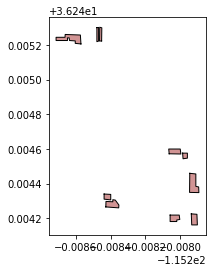

In [125]:
import shapely.geometry
meta_df.set_geometry(meta_df.geometry.apply(shapely.geometry.Polygon), inplace=True)
meta_df.plot(color='brown')

In [126]:
all_panels = meta_df.unary_union


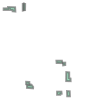

In [127]:
all_panels

In [128]:
file_name = filename2
print(file_name)
with rasterio.open(file_name) as src:
        img = scale_bands(src.read([5, 3, 2]).transpose([1,2,0]))
        img_bounds = shapely.geometry.box(*src.bounds)
        img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])

MUL-PanSharpen/MUL-PanSharpen_AOI_2_Vegas_img3888.tif


/home/ubuntu/anaconda2/envs/scienv2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2882: DeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [129]:
img_transform#_bounds#.plot(color='brown')

[370370.37037277053,
 0.0,
 0.0,
 -370370.37036977155,
 42670088.000276521,
 13424400.999978296]

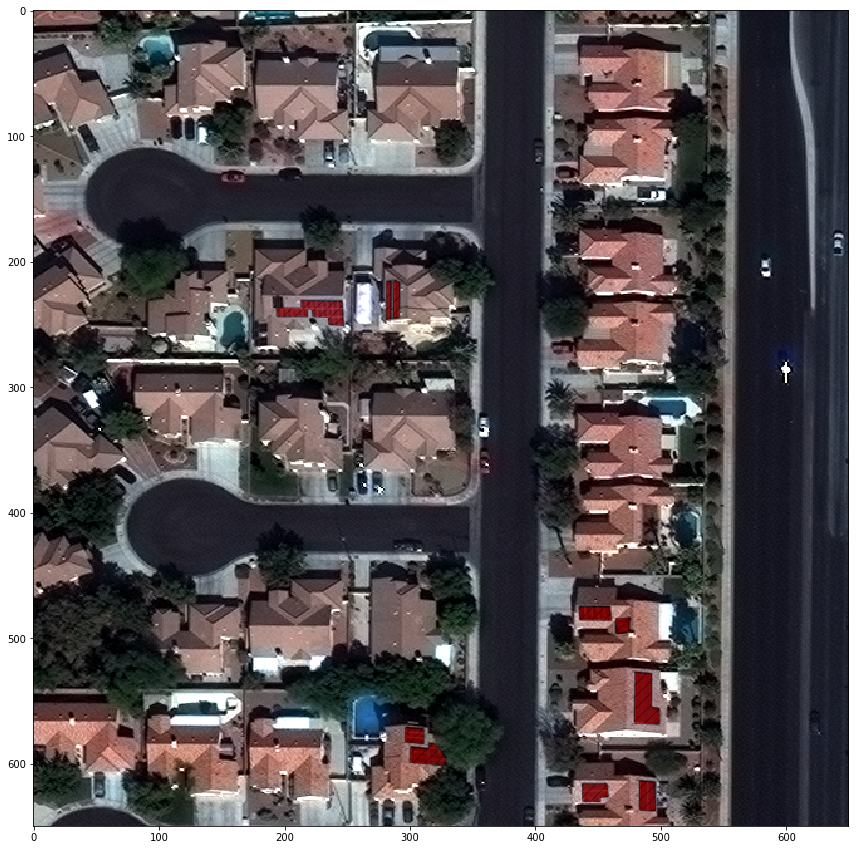

In [130]:
from descartes import PolygonPatch

# Get the intersection between the forest and the image bounds
panels = all_panels.intersection(img_bounds)
#all_panels
#img_bounds
#meta_df
#panels

# Transform it into pixel coordinates
panels_pxcoords = shapely.affinity.affine_transform(panels, img_transform)

fig, ax = plt.subplots(figsize=(15,15))

# Plot the image
ax.imshow(scale_bands(img))

# Plot the forest on top of the image
ax.add_patch(PolygonPatch(panels_pxcoords, fc='r', alpha=0.4, hatch='//'))

## Make mask with solar panel ground truth

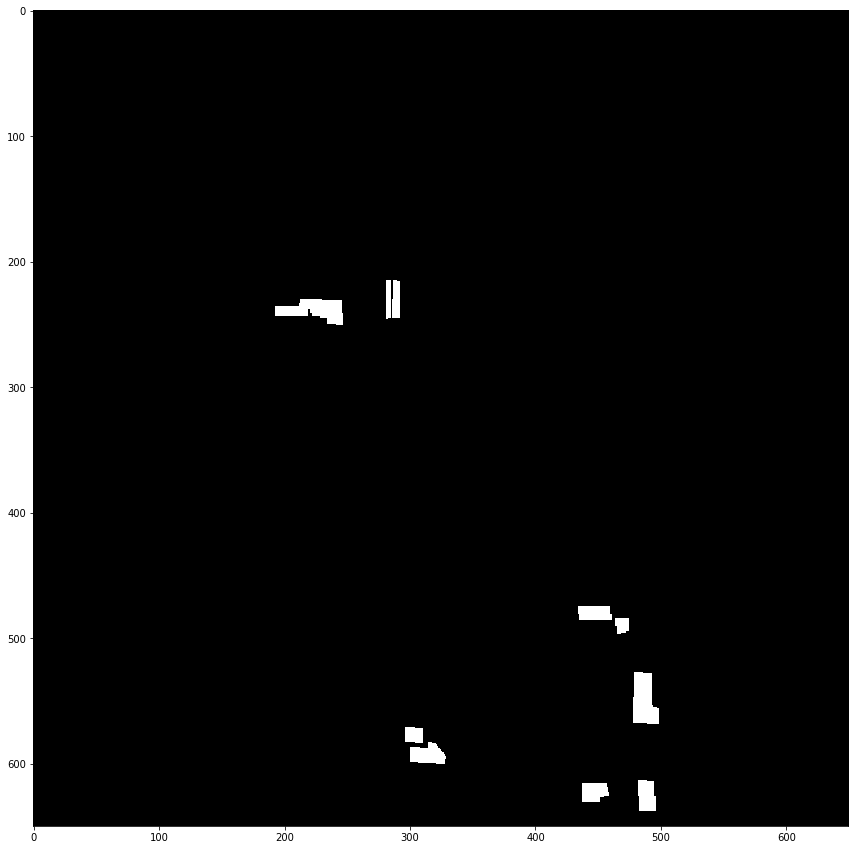

In [131]:
import cv2

def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

# Convert the forest polygon into a mask
panels_mask = make_mask(img.shape, panels_pxcoords)

# Plot it
fig, ax = plt.subplots(figsize=(15,15))

plt.imshow(panels_mask, cmap=plt.cm.gray)

## See if Spacenet data includes house footprints

In [97]:
# Load the image summary
image_summary = gpd.read_file('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/MUL-PanSharpen/vegas_image_summary.geojson')

# Load the nature data from OSM
osm_landuse = gpd.read_file('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/MUL-PanSharpen/landuse_n.geojson')

# Convert everything to polygons
osm_landuse.set_geometry(osm_landuse.geometry.apply(shapely.geometry.Polygon), inplace=True)

# Limit to just residential
residential = osm_landuse[osm_landuse.landuse == 'residential'].unary_union
forest = osm_landuse[osm_landuse.landuse == 'forest'].unary_union

# Now do the same for water
osm_nature = gpd.read_file('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/MUL-PanSharpen/nature_n.geojson')
osm_nature.set_geometry(osm_nature.geometry.apply(shapely.geometry.Polygon), inplace=True)
water = osm_nature[osm_nature.natural == 'water'].unary_union

# Now do the same for buildings
building_footprints_i = gpd.read_file('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/building_fooprints_f.geojson')
print(len(building_footprints_i))
building_footprints_i["buffered_geometry"] = building_footprints_i["geometry"].buffer(0)
building_footprints_i = building_footprints_i.drop("geometry", axis = 1)
building_footprints_i = building_footprints_i.rename(columns = {'buffered_geometry':'geometry'})
# nulls = building_footprints_i[building_footprints_i.geometry == []]
# nulls
building_footprints= building_footprints_i.copy()
#building_footprints.set_geometry(building_footprints.geometry.apply(shapely.geometry.Polygon), inplace=True)
buildings = building_footprints.unary_union

vectors = [buildings]

109807


In [98]:
building_footprints_check = building_footprints[building_footprints['ImageId']=='AOI_2_Vegas_img3888']

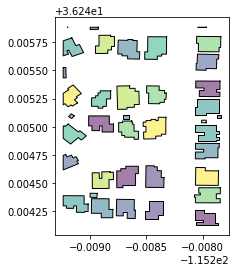

In [99]:
building_footprints_check.plot()

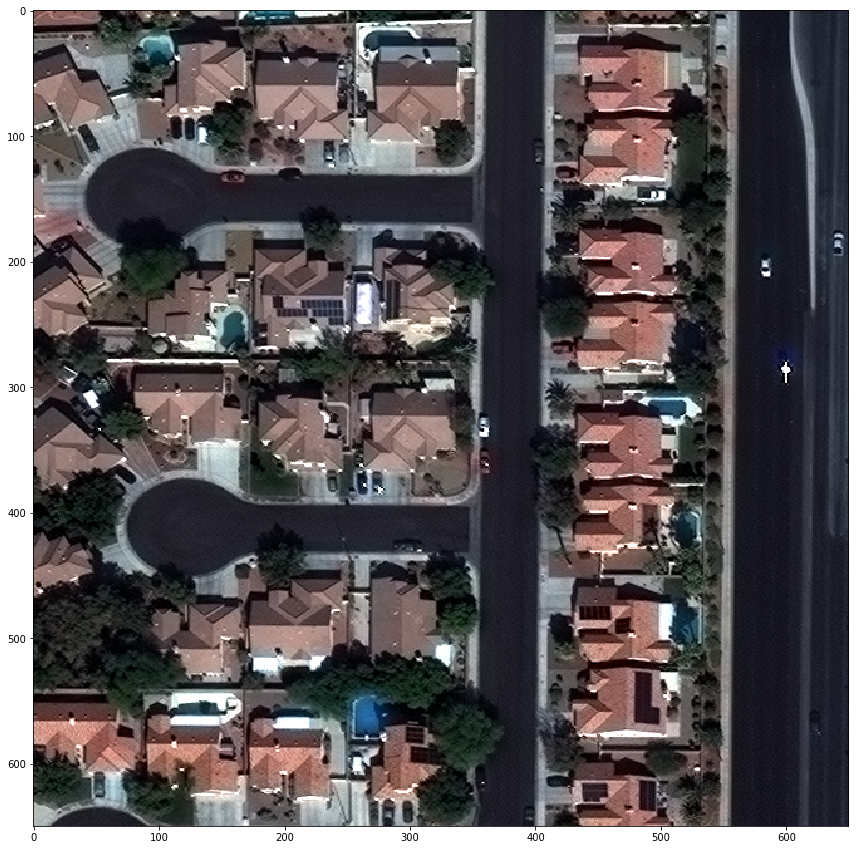

In [101]:
src = rasterio.open('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/MUL-PanSharpen/MUL-PanSharpen_AOI_2_Vegas_img3888.tif')
img = src.read([5, 3, 2]).transpose([1,2,0])
def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image for display
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    
    for i in range(img.shape[2]):
        
        band = img[:, :, i]
        
        # Pick out the lower and upper percentiles
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        
        # Normalize the band
        band = (band - lower) / (upper - lower) * 255
        
        # Clip the high and low values, and cast to uint8
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
        
    return img_scaled


# Plot the rescaled image
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(scale_bands(img))

In [102]:
with rasterio.open('/home/vaston/Metis_Project_5/Las_Vegas_Pictures/AOI_2_Vegas_Train/MUL-PanSharpen/MUL-PanSharpen_AOI_2_Vegas_img3888.tif') as src:
        img = scale_bands(src.read([5, 3, 2]).transpose([1,2,0]))
        img_bounds = shapely.geometry.box(*src.bounds)
        img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])
        img_crs = src.crs

/home/ubuntu/anaconda2/envs/scienv2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2882: DeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


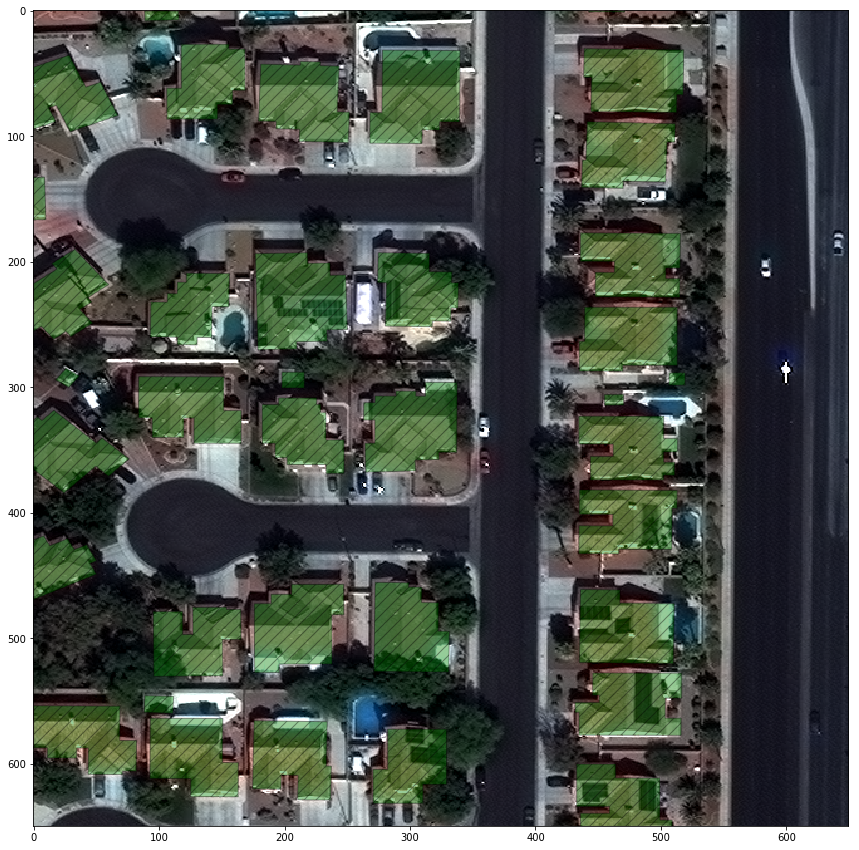

In [132]:
from descartes import PolygonPatch

# Get the intersection between the forest and the image bounds
image_building_area = vectors[0].intersection(img_bounds)

# Transform it into pixel coordinates
image_building_area_pxcoords = shapely.affinity.affine_transform(image_building_area, img_transform)

fig, ax = plt.subplots(figsize=(15,15))

# Plot the image
ax.imshow(scale_bands(img))

# Plot the forest on top of the image
ax.add_patch(PolygonPatch(image_building_area_pxcoords, fc='g', alpha=0.4, hatch='//'))

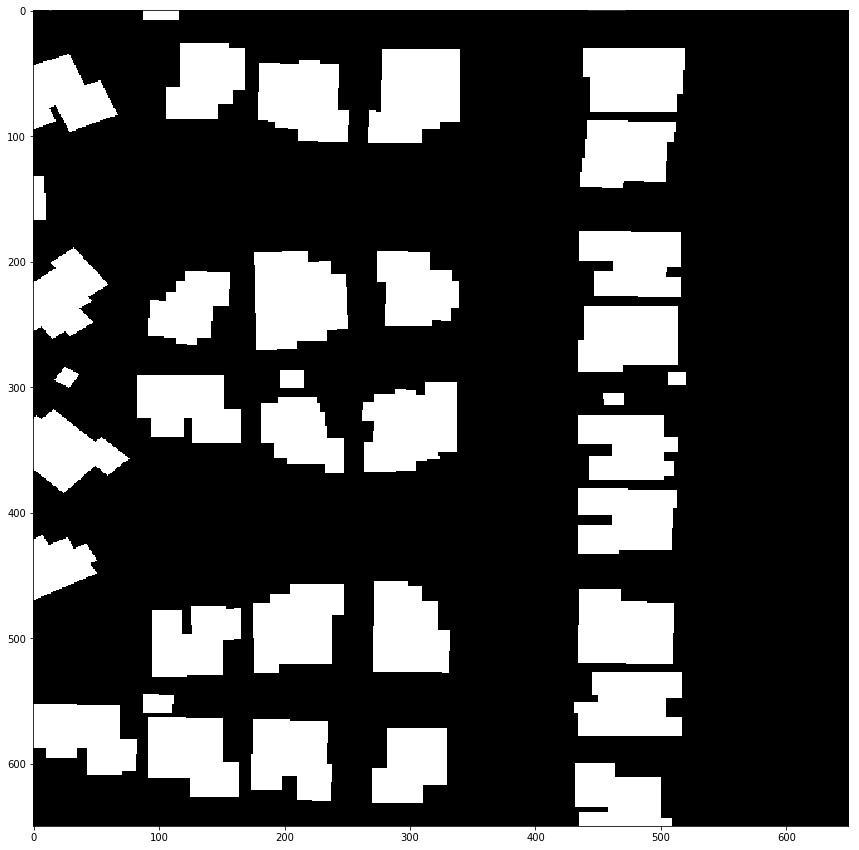

In [134]:
import cv2

def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

# Convert the forest polygon into a mask
building_mask = make_mask(img.shape, image_building_area_pxcoords)

# Plot it
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(building_mask, cmap=plt.cm.gray)